In [1]:
%matplotlib inline

In [2]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.2 MB/s eta 0:00:00


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [4]:
n_epochs = 30
n_layers = 1
n_train = 50
n_test = 30

SAVE_PATH = ""
PREPROCESS = True
np.random.seed(0)
tf.random.set_seed(0)

In [5]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images / 255
test_images = test_images / 255

train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    RandomLayers(rand_params, wires=list(range(4)))

    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [7]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [12]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:


KeyboardInterrupt: 

In [9]:
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

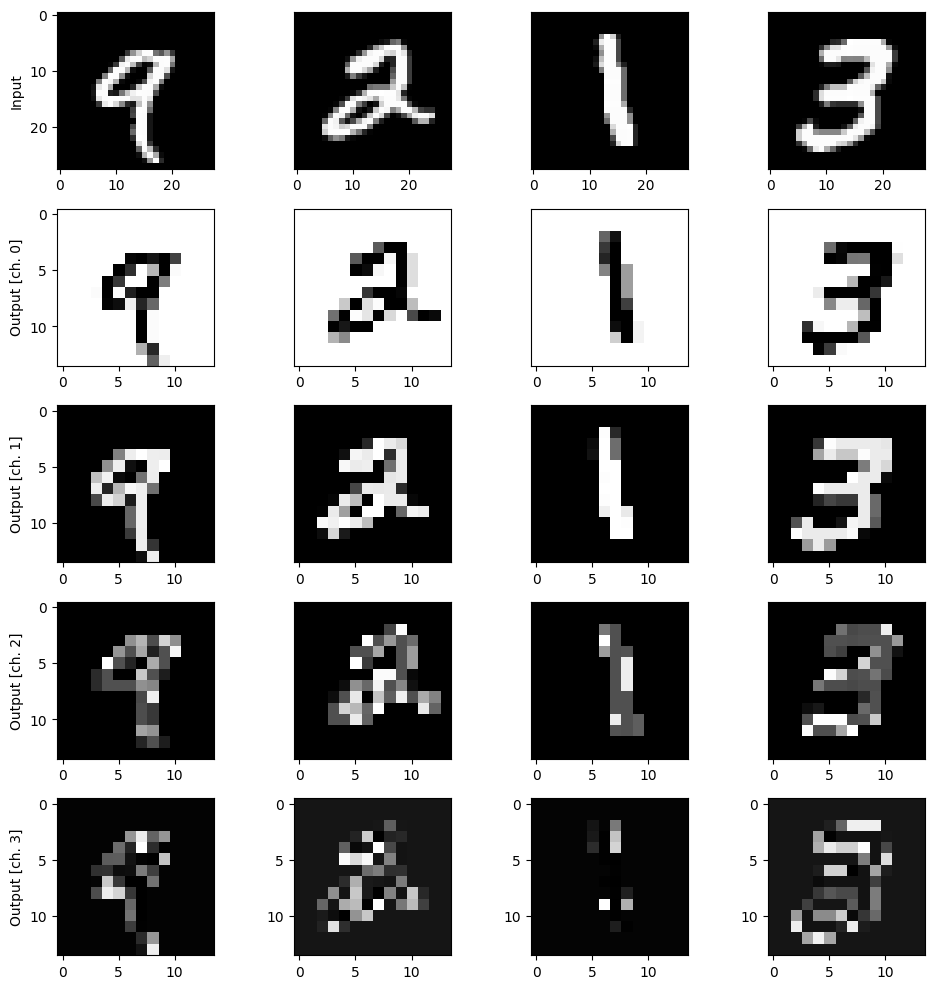

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k+4, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k+4, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [16]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [17]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 111ms/step - accuracy: 0.1400 - loss: 2.6415 - val_accuracy: 0.2000 - val_loss: 2.2320
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.3600 - loss: 1.9304 - val_accuracy: 0.3333 - val_loss: 2.0359
Epoch 3/30
13/13 - 0s - 7ms/step - accuracy: 0.6000 - loss: 1.6032 - val_accuracy: 0.4000 - val_loss: 1.8550
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.7400 - loss: 1.3127 - val_accuracy: 0.3667 - val_loss: 1.7216
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.9000 - loss: 1.0838 - val_accuracy: 0.5000 - val_loss: 1.6164
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.8998 - val_accuracy: 0.5667 - val_loss: 1.5300
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.7574 - val_accuracy: 0.5333 - val_loss: 1.4597
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9800 - loss: 0.6428 - val_accuracy: 0.6000 - val_loss: 1.4007
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 0.9800 - loss: 0.5501 - val_accuracy: 0.6000 - val_loss: 1.3515
Epoch 10/30
13/

In [18]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 89ms/step - accuracy: 0.2600 - loss: 2.2072 - val_accuracy: 0.2000 - val_loss: 2.2900
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.5400 - loss: 1.8232 - val_accuracy: 0.3333 - val_loss: 2.1265
Epoch 3/30
13/13 - 0s - 9ms/step - accuracy: 0.6000 - loss: 1.5534 - val_accuracy: 0.3667 - val_loss: 1.9791
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.7600 - loss: 1.3284 - val_accuracy: 0.4000 - val_loss: 1.8501
Epoch 5/30
13/13 - 0s - 8ms/step - accuracy: 0.8400 - loss: 1.1410 - val_accuracy: 0.4667 - val_loss: 1.7410
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9200 - loss: 0.9864 - val_accuracy: 0.4667 - val_loss: 1.6506
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9400 - loss: 0.8590 - val_accuracy: 0.5333 - val_loss: 1.5762
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.7536 - val_accuracy: 0.5333 - val_loss: 1.5145
Epoch 9/30
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.6657 - val_accuracy: 0.6000 - val_loss: 1.4630
Epoch 10/30
13/13

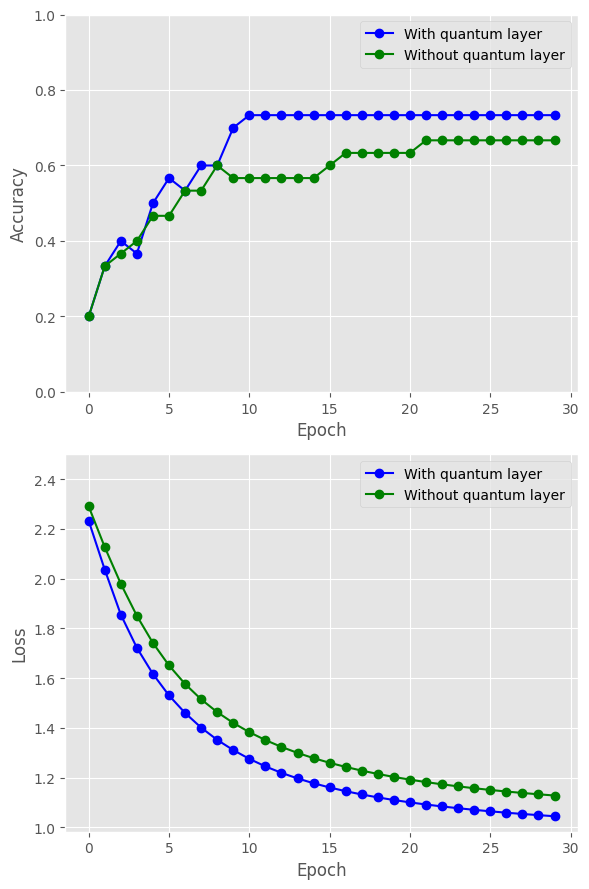

In [20]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()